# Week 8 Exploratory Data Project
##### November 10, 2021 - Angela Spencer and Clarine Esperance

## Executive Summary

For this project we used data from the http://audiodb.com which uses a JSON API and contains information on over 53,000 artists. In order to pull a managable amount of data, we created a list of randomly generated numbers within the range of available artist IDs. This list was used to loop through the database URLs and pull information on all available artist IDs in the list. From this information we created a new list with artist names corresponding to the aritst IDs. With the new list of artist IDs we were able to loop through database URLs to populate a dictionary with data, including: artist ID, artist name, gender, number of members, music style/genre, year formed, year disbanded, and location. From this dictionary we created a dataframe in order to view and analyze the information.

For this particular database, values and null values were added without specific guidelines so data cleaning was necessary.  We replaced all 0 values (0, None, Null, NaN, “empty strings”) with Null and spent time replacing location strings (states, cities, and spelling variations were present) with a single country string. We then created individual variable for dataframes where all rows with null values in that column had been dropped.  We found that this method preserved more data than drop any row with a null value.

In analyzing the data, we began with a list of 600+ artists and analyzed by location, genre, gender, and year formed. We found that the majority of the database contains artists from the United States and United Kingdom, representing 30% and 18% of the database, respectively.  The most common genre is Pop, representing 8% of the database. The most common gender is male, representing 73% of the database.  The range of years represented are from a minimum of 1670 to a maximum of 2020.  In analyzing the data by multiple categories, we discovered that the top genre for artists in the United States is Hip-Hop while the top genre for artists in the United Kingdom is Pop.  Looking at the top 3 genres overall (Pop, Jazz, and Rock), we see that the range of years for artists and bands forming for Pop is 1981-2016, for Jazz the range is 1885-1995, and for Rock the range is 1969-2018. 

These analyses are visually represented with graphs throughout the report.  Because the vast majority of our data is categorical rather than numerical, there are many pie charts and bar graphs to represent the relationships contained within the dataset.

In [1]:
#Dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import time
from pprint import pprint
import json

In [2]:
#modules for statistics
import math
import statistics
from scipy import stats

# Generate Artists List

In [3]:
# Find a code to get all the artists from this api
#https://www.theaudiodb.com/api_guide.php
# theaudiodb.com/api/v1/json/1/search.php?s=coldplay

#empty list to be populated with artist names
artist_names = []

In [4]:
#generate random numbers in the range of available artist IDs
#used to populate artist_names list
random_nums = np.random.randint(low=100000, high=170000, size=1000)

#test with known IDs and intentional errors
#random_nums = [112024, 0, 100000, 114364]

In [5]:
#create a base url
#example: https://theaudiodb.com/api/v1/json/1/artist.php?i=112024
id_url = "https://theaudiodb.com/api/v1/json/1/artist.php?i="

#create a loop that uses random numbers list
for num in random_nums:
    unique_url = id_url + f'{num}'
    
    #call api url
    request = requests.get(unique_url)
    
    #for each attempt try to convert information to json
    try:
        #convert to json
        info = request.json()
    
    #exception json decode error
    #https://docs.python.org/3/tutorial/controlflow.html
    except json.JSONDecodeError:
        #end this iteration and continue new iteration of for loop
        continue
    
    #if json conversion successful then
    #try to create a variable for single artist to reference later
    try:
        artist = info['artists'][0]['strArtist']
        
    #TypeError exception if url responds with {'artists': None}
    except (TypeError):
        continue
        
    #if the artist is not already in the list then 
    if artist not in artist_names:
        
        #populate artist_names list using info(json)
        #response-> {'artists': [{'idArtist': '114364', 'strArtist': 'Beyoncé', ...
        #dictionary{'artists':['{dictionary}']}
        artist_names.append(info['artists'][0]['strArtist'])
    
    #print(artist_names)

In [6]:
len(artist_names)

760

# Generate Dictionary of Artist Data

In [7]:
#create loop to pull artist information from the database
#using populated artist_names list
#example url: http://theaudiodb.com/api/v1/json/1/search.php?s=coldplay
#tutorial: https://www.youtube.com/watch?v=pxofwuWTs7c

#create empty dictionary to fill with values
audio_data = {'artist_id':[],
              'artist_name':[],
              'gender':[],
              'members':[],
              'style':[], 
              'genre':[],
             'year_formed':[],
             'year_disbanded':[],
             'location':[]}

#for each artist in the artist list, 
for name in artist_names:
    
    #add the artist name to the base url
    base_url = "http://theaudiodb.com/api/v1/json/1/search.php?s="
    req = requests.get(base_url + f'{name}')
    
    #convert request information into json as a variable
    data = req.json()
    
    #add json values to dictionary
    try:
        audio_data['artist_id'].append(data['artists'][0]['idArtist'])
        audio_data['artist_name'].append(data['artists'][0]['strArtist'])
        audio_data['gender'].append(data['artists'][0]["strGender"])
        audio_data['members'].append(data['artists'][0]["intMembers"])
        audio_data['style'].append(data['artists'][0]["strStyle"])
        audio_data['genre'].append(data['artists'][0]["strGenre"])
        audio_data['year_formed'].append(data['artists'][0]["intFormedYear"])
        audio_data['year_disbanded'].append(data['artists'][0]["strDisbanded"])
        audio_data['location'].append(data['artists'][0]["strCountry"])
    
    #restart loop if TypeError found
    except (TypeError):
        continue

#### Convert Dictionary to DataFrame

In [8]:
audio_df = pd.DataFrame(audio_data)
audio_df.head(5)

,artist_id,artist_name,gender,members,style,genre,year_formed,year_disbanded,location
0,121769,Joe Garston,Male,1,Electronic,House,2011,None,"Liverpool, United Kingdom"
1,147566,Artie Traum,None,None,None,Folk,1943,None,None
2,116735,Crest of Darkness,None,None,None,None,0,None,None
3,130174,Henny Youngman,None,None,None,None,1906,None,None
4,117928,Namie Amuro,Female,1,Rock/Pop,J-Pop,1977,None,"Naha, Okinawa, Japan"


# Cleaning Data

#### Cleaning null data
Cleaning the data to ensure that all null values are represented in the same way.  This data contains NaN, Null, None, and empty string '' --all representing missing values.  We replaced these missing values with Null with null. For year disbanded, replaced None with no, meaning that they haven't disbanded.

In [9]:
#To only replace empty values for one column, specify the column name for the DataFrame:

audio_df['year_disbanded'].replace({2021 : 'No'}, inplace = True)
#audio_df_nan = audio_df.replace(0, np.nan)
audio_df['year_formed'].replace({None: 'Null', '0' : np.nan}, inplace = True) 
audio_df['gender'].replace({None: 'Null', '' : 'Null'}, inplace = True) 
audio_df['location'].replace({None: 'Null', '' : 'Null'}, inplace = True)
audio_df['style'].replace({'' : 'Null', None : 'Null'}, inplace = True)
audio_df['genre'].replace({'' : 'Null'}, inplace = True)

audio_df.head(10)

,artist_id,artist_name,gender,members,style,genre,year_formed,year_disbanded,location
0,121769,Joe Garston,Male,1,Electronic,House,2011,None,"Liverpool, United Kingdom"
1,147566,Artie Traum,Null,None,Null,Folk,1943,None,Null
2,116735,Crest of Darkness,Null,None,Null,None,NaN,None,Null
3,130174,Henny Youngman,Null,None,Null,None,1906,None,Null
4,117928,Namie Amuro,Female,1,Rock/Pop,J-Pop,1977,None,"Naha, Okinawa, Japan"
5,163199,Working Men’s Club,Male,4,Electronic,Indie,NaN,None,Null
6,139698,The Cannonball Adderley Quintet,Null,1,Null,Jazz,NaN,None,Null
7,143994,The Comsat Angels,Male,4,Rock/Pop,New Wave,1979,Yes,"Sheffield, UK"
8,151392,Sari Schorr,Female,1,Null,Blues,NaN,None,Null
9,113614,Die Ärzte,Male,3,Rock/Pop,Rock,1982,None,"Berlin, Germany"


#### Cleaning Location Data
Location data in this dataframe has no consistent format, we occasionally found states only, cities only, and variable spelling of countries.  This code replaces many possible substrings with a single string.

In [10]:
#replacing and correcting location strings
#replace strings that contain a given value with an entire string

audio_df.loc[audio_df['location'].str.contains
             ('US|American|New York|Sacramento|Colorado|Missouri|Chicago|Tennessee|California|Florida|Indiana|Texas|Los Angeles|Elk Grove Village|Arizona|Arlington', 
              na=False, case=False, regex=True), 'location'] = 'USA'
audio_df.loc[audio_df['location'].str.contains
             ('UK|England|English|Edinburgh|London|Scotland|Irish|Ireland|Manchester|United Kingdom|Nottingham|Croydon|Liverpool', 
              na=False, case=False, regex=True), 'location'] = 'UK'
audio_df.loc[audio_df['location'].str.contains
             ('German|Deutsch|Deutch', 
              na=False, case=False, regex=True), 'location'] = 'Germany'
audio_df.loc[audio_df['location'].str.contains
             ('Italia|Italy|Livorno', 
              na=False, case=False, regex=True), 'location'] = 'Italy'
audio_df.loc[audio_df['location'].str.contains
             ('France|French|Livorno|Paris', 
              na=False, case=False, regex=True), 'location'] = 'France'
audio_df.loc[audio_df['location'].str.contains
             ('Belgium', 
              na=False, case=False, regex=True), 'location'] = 'Belgium'
audio_df.loc[audio_df['location'].str.contains
             ('Greece|Greek', 
              na=False, case=False, regex=True), 'location'] = 'Greece'
audio_df.loc[audio_df['location'].str.contains
             ('Switzerland|Swiss', 
              na=False, case=False, regex=True), 'location'] = 'Switzerland'
audio_df.loc[audio_df['location'].str.contains
             ('Canada|Canadian|Ontario', 
              na=False, case=False, regex=True), 'location'] = 'Canada'
audio_df.loc[audio_df['location'].str.contains
             ('Melbourne|Australia', 
              na=False, case=False, regex=True), 'location'] = 'Japan'
audio_df.loc[audio_df['location'].str.contains
             ('Japan|Japanese', 
              na=False, case=False, regex=True), 'location'] = 'Japan'
audio_df.loc[audio_df['location'].str.contains
             ('Poznań|Poland', 
              na=False, case=False, regex=True), 'location'] = 'Poland'
audio_df.loc[audio_df['location'].str.contains
             ('Россия|Moscow', 
              na=False, case=False, regex=True), 'location'] = 'Russia'
audio_df.loc[audio_df['location'].str.contains
             ('Portugal', 
              na=False, case=False, regex=True), 'location'] = 'Portugal'
audio_df.loc[audio_df['location'].str.contains
             ('Swede|Gothenburg', 
              na=False, case=False, regex=True), 'location'] = 'Sweden'
audio_df.loc[audio_df['location'].str.contains
             ('Odense', 
              na=False, case=False, regex=True), 'location'] = 'Denmark'
audio_df.loc[audio_df['location'].str.contains
             ('Dutch|Netherlands', 
              na=False, case=False, regex=True), 'location'] = 'Netherlands'
audio_df.loc[audio_df['location'].str.contains
             ('Zealand|Wellington', 
              na=False, case=False, regex=True), 'location'] = 'New Zealand'
audio_df.loc[audio_df['location'].str.contains
             ('Rumania', 
              na=False, case=False, regex=True), 'location'] = 'Romania'
audio_df.loc[audio_df['location'].str.contains
             ('South Africa', 
              na=False, case=False, regex=True), 'location'] = 'South Africa'
audio_df.loc[audio_df['location'].str.contains
             ('Argentina', 
              na=False, case=False, regex=True), 'location'] = 'Argentina'
audio_df.loc[audio_df['location'].str.contains
             ('Mexico', 
              na=False, case=False, regex=True), 'location'] = 'Mexico'


#### Dropping Null Data
We created variable to represent dataframes with the null valuse removed for a single column for further analysis

In [11]:
#REPLACE AND DROP NAN FOR INDIVIDUAL COLUMNS
#assign individual variables for individual columns with null dropped

#replace 'Null' with NaN for all values in location column, drop NaN
location_na = audio_df.replace({'location': r'Null'}, {'location': np.nan}, regex=True)
location_dropped = location_na.dropna(axis=0, subset=['location'], inplace=False)
#location_dropped

#replace 'Null' with NaN for all values in genre column, drop NaN
genre_na = audio_df.replace({'genre': r'Null'}, {'genre': np.nan}, regex=True)
genre_dropped = genre_na.dropna(axis=0, subset=['genre'], inplace=False)
#genre_dropped

#replace 'Null' with NaN for all values in genre column, drop NaN
gender_na = audio_df.replace({'gender': r'Null'}, {'gender': np.nan}, regex=True)
gender_dropped = gender_na.dropna(axis=0, subset=['gender'], inplace=False)
#gender_dropped

#replace 'Null' with NaN for all values in year_formed column, drop NaN
year_formed_na = audio_df.replace({'year_formed': r'Null'}, {'year_formed': np.nan}, regex=True)
year_formed_dropped = year_formed_na.dropna(axis=0, subset=['year_formed'], inplace=False)
#year_formed_dropped

# Analysis of the Data

## Location Analysis

#### Location Count

In [12]:
#LOCATION COUNT - NULL DROPPED

#number of times each location appears in the dataframe
location_counts_dropped = location_dropped['location'].value_counts()

#series
location_counts_dropped

#create dictionary and convert to df
location_counts_dict = {'Artist Location':location_counts_dropped}
location_counts_df = pd.DataFrame(location_counts_dict)

#top 10 artist locations
location_top10 = location_counts_df.head(10)
location_top10

,Artist Location
USA,96
UK,63
Germany,17
France,14
Canada,9
Italy,8
Sweden,5
Argentina,5
Netherlands,3
Denmark,3


#### Location Proportion

In [13]:
#LOCATION PROPORTION - NULL DROPPED

#proportion each location represents in the data
location_proportion_dropped = round(location_counts_dropped / location_counts_dropped.sum(), 3)

#series
location_proportion_dropped

#create dictionary and convert to df
location_proportion_dict = {'Artist Location Proportion':location_proportion_dropped}
location_proportion_df = pd.DataFrame(location_proportion_dict)

#top 10 by proportion
location_proportion_top10 = location_proportion_df.head(10)
location_proportion_top10

,Artist Location Proportion
USA,0.286
UK,0.188
Germany,0.051
France,0.042
Canada,0.027
Italy,0.024
Sweden,0.015
Argentina,0.015
Netherlands,0.009
Denmark,0.009


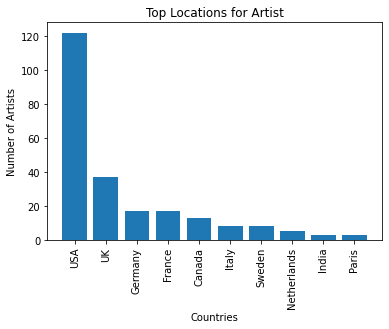

In [14]:
x = np.array(["USA", "UK", "Germany", "France", "Canada", "Italy", "Sweden", "Netherlands", "India", "Paris"])
y = np.array([122, 37, 17, 17, 13, 8, 8, 5, 3, 3])

plt.bar(x,y)
plt.title('Top Locations for Artist')
plt.xlabel('Countries')
plt.ylabel('Number of Artists')
plt.xticks(rotation='vertical')
plt.show()

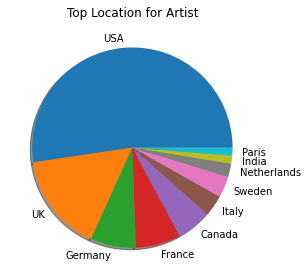

In [15]:
x = [122, 37, 17, 17, 13, 8, 8, 5, 3, 3]
labels = ["USA", "UK", "Germany", "France", "Canada", "Italy", "Sweden", "Netherlands", "India", "Paris"]

fig, ax = plt.subplots()
ax.pie(x, labels=labels, shadow = True)
ax.set_title('Top Location for Artist')
plt.tight_layout()
plt.show()

## Genre Analysis

#### Genre Mode

The value that appears most frequently in the genre column is Pop.

In [16]:
#The mode shows the most frequently occuring value in a column

statistics.mode(genre_dropped['genre'])

'Pop'

#### Genre Count

In [17]:
#GENRE COUNT - NULL DROPPED

#count of unique genres, excluding null values
genre_counts_dropped = genre_dropped['genre'].value_counts()

#series
genre_counts_dropped

#create dictionary and convert to df
genre_counts_dict = {'Genre Count':genre_counts_dropped}
genre_counts_df = pd.DataFrame(genre_counts_dict)

#top 10 by proportion
genre_counts_top10 = genre_counts_df.head(10)
genre_counts_top10

,Genre Count
Pop,29
Jazz,24
Rock,22
Classical,21
Folk,19
R&B,13
Indie,12
Blues,12
Progressive Rock,10
Alternative Rock,10


#### Genre Proportion

In [18]:
#GENRE PROPORTION - NULL DROPPED

#proportion each genre represents in the data
genre_proportion_dropped = round(genre_counts_dropped / genre_counts_dropped.sum(), 3)

#series
genre_proportion_dropped

#create dictionary and convert to df
genre_proportion_dict = {'Genre Proportion':genre_proportion_dropped}
genre_proportion_df = pd.DataFrame(genre_proportion_dict)

#top 10 by proportion
genre_proportion_top10 = genre_proportion_df.head(10)
genre_proportion_top10

,Genre Proportion
Pop,0.066
Jazz,0.055
Rock,0.050
Classical,0.048
Folk,0.043
R&B,0.030
Indie,0.027
Blues,0.027
Progressive Rock,0.023
Alternative Rock,0.023


NameError: name 'myexplode' is not defined

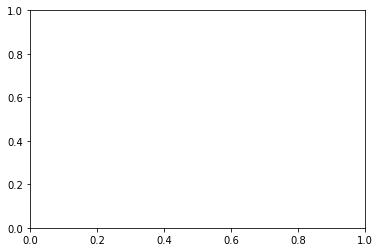

In [19]:
x = [37, 25, 21, 19, 17]
labels = ["Pop", "Jazz", "Hip-Hop", "Rock", "Folk"]

fig, ax = plt.subplots()
ax.pie(x, labels=labels, explode = myexplode, shadow = True)
ax.set_title('Popular Genres among Artist')
plt.tight_layout()
plt.show()

In [ ]:
x = ["Pop", "Jazz", "Hip-Hop", "Rock", "Folk"]
y = [37, 25, 21, 19, 17]

plt.bar(x, y, color = "purple")
plt.title('Popular Genres among Artists')
plt.xlabel('Genre')
plt.ylabel('Number of Artists')
plt.show()

## Gender 

Show calculations for null values included and null values removed.

#### Gender Mode

Male artists and groups are more common that female or mixed gender groups.

In [ ]:
statistics.mode(gender_dropped['gender'])

#### Gender Count

In [ ]:
#GENDER COUNT - NULL DROPPED

#count of unique genres, excluding null values
gender_counts_dropped = gender_dropped['gender'].value_counts()

#series
gender_counts_dropped

#create dictionary and convert to df
gender_counts_dict = {'Gender Count':gender_counts_dropped}
gender_counts_df = pd.DataFrame(gender_counts_dict)
gender_counts_df

#### Gender Proportion

In [ ]:
#GENDER PROPORTION - NULL DROPPED

#proportion each genre represents in the data
gender_proportion_dropped = round(gender_counts_dropped / gender_counts_dropped.sum(), 2)

#series
gender_proportion_dropped

#create dictionary and convert to df
gender_proportion_dict = {'Gender Proportion':gender_proportion_dropped}
gender_proportion_df = pd.DataFrame(gender_proportion_dict)
gender_proportion_df

In [ ]:
category_order = ['Male', 'Female', 'Mixed']

sns.countplot(x = gender_dropped['gender'], data = audio_df, order = category_order)
plt.title('Gender of Artists/Bands')
plt.show()

In [ ]:
x = [305, 85, 48]
labels = ['Male', 'Female', 'Mixed']

fig, ax = plt.subplots()
ax.pie(x, labels=labels, explode = myexplode, shadow = True)
ax.set_title('Gender of Artists/Bands')
plt.tight_layout()
plt.show()

## Year Formed

In [ ]:
#Find the max year
max_year_formed = year_formed_dropped['year_formed'].max()
max_year_formed

In [ ]:
#Find the max year
min_year_formed = year_formed_dropped['year_formed'].min()
min_year_formed

In [ ]:
#Find the number of band formed each year
year_count = year_formed_dropped.groupby('year_formed').size()

#create dictionary and convert to df
year_count_dict = {'Year Count':year_count}
year_count_df = pd.DataFrame(year_count_dict)
year_count_df

In [ ]:
#delete since it doens't tell us much

n, bins, patches = plt.hist(year_count_df['Year Count'])

## Analysis on Multiple Columns

#### Genres by Top 3 Locations

An analysis of the genres in the top 3 countries

In [ ]:
#Genre by Location
#GROUPBYS WITH NULL VALUES DROPPED

#create new vartiables = one df with null values in 'genre' and 'location' dropped
genre_location_na = location_na.replace({'genre': r'Null'}, {'genre': np.nan}, regex=True)
genre_location_dropped = genre_location_na.dropna(axis=0, subset=['genre'], inplace=False)
genre_location_na.dropna(axis=0, subset=['location'], inplace=False)
genre_location_dropped

#groupby location
genre_location_grouped = genre_location_dropped.groupby('location')

#count location by genre
genre_by_location = genre_location_grouped['genre'].value_counts()

#sort values in descending order
genre_by_location_sorted = genre_by_location.sort_values(ascending=False)

#isolate top 3 locations
genre_by_location_top3 = genre_by_location_sorted.loc[['USA', 'UK', 'Germany']]

genre_by_location_top3

#create dictionary and convert to df
genre_by_location_top3_dict = {'Genre by Location':genre_by_location_top3}
genre_by_location_top3_df = pd.DataFrame(genre_by_location_top3_dict)
genre_by_location_top3_df

In [ ]:
#sns.catplot(x = 'Genre by Location', data = genre_by_location_top3_df);

#genre_by_location_top3_df.plot(kind='bar', stacked=True)

#fig, ax = plt.subplots()
# First plot the 'USA' bars for genre.
#ax.bar(genre_by_location_top3_df.index, genre_by_location_top3_df['USA'], label='USA')
# Then plot the 'Female' bars on top, starting at the top of the 'Male'
# bars.
#ax.bar(genre_by_location_top3_df.index, genre_by_location_top3_df['UK'], bottom=genre_by_location_top3_df['USA'],
#       label='UK')
#ax.set_title('Genre by Location')
#ax.legend()

#### Genres by Year

An analysis of the year that bands formed and the genre that play in.

In [ ]:
#Genre by Year
#GROUPBYS WITH NULL VALUES DROPPED

#create new vartiables = one df with null values in 'genre' and 'year_formed' dropped
genre_year_na = genre_na.replace({'year_formed': r'Null'}, {'year_formed': np.nan}, regex=True)
genre_year_dropped = genre_year_na.dropna(axis=0, subset=['year_formed'], inplace=False)
genre_year_dropped

#groupby year formed
year_genre_grouped = genre_year_dropped.groupby('genre')

#count genre on year formed groupby
year_by_genre = year_genre_grouped['year_formed'].value_counts()

year_by_genre_top3 = year_by_genre.loc[['Pop', 'Jazz', 'Rock']]

#create dictionary and convert to df
year_by_genre_top3_dict = {'Genre by Year':year_by_genre_top3}
year_by_genre_top3_df = pd.DataFrame(year_by_genre_top3_dict)
genre_by_location_top3_df

In [ ]:
#sns.catplot(x = 'year_formed', y = 'Genre by Year', hue = 'genre', data= genre_by_location_top3_df);
#sns.countplot(x = year_formed, y = data = audio_df)

Notes for questions and stats to run:
1. This data is categorical and nominal (unordered)
2. Best to use counts and bar graphs for categorical data
3. Measure of center: Mode - used to categorical data b/c the variables don't have a numerical representation and use the function in stats module: statistics.mode

Questions:

Which artist released the most albums?
Which genre has the most artists?
Is there a relationship between genre and location?

Maybe create a second dataframe with discography api. If so, more questions that could be answered? Year and genre?

- Do groups or individual artist release more albums?
- Which category do the albums fall into?